<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_pandas_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Parquet Derivatives

In this notebook, we'll setup an enviroment, then load nine different DataFrames to experiment with.

**[Binary Analysis](https://github.com/archivesunleashed/aut/wiki/Bleeding-Edge#list-of-domains)**
- [Audio](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/binary-analysis.md#Extract-Audio-Information)
- [Images](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/image-analysis.md#Extract-Image-information)
- [PDFs](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/binary-analysis.md#Extract-PDF-Information)
- [Presentation program files](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/binary-analysis.md#Extract-Presentation-Program-Files-Information)
- [Spreadsheets](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/binary-analysis.md#Extract-Spreadsheet-Information)
- [Videos](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/binary-analysis.md#Extract-Video-Information)
- [Word processor files](hhttps://github.com/archivesunleashed/aut-docs-new/blob/master/current/binary-analysis.md#Extract-Word-Processor-Files-Information)

**[Hyperlink Network](https://github.com/archivesunleashed/aut/wiki/Bleeding-Edge#hyperlink-network)**

**[List of Domains](https://github.com/archivesunleashed/aut/wiki/Bleeding-Edge#list-of-domains)**

# Dataset

We will need web archive dataset to work with.

The one we'll use in this example notebook comes from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup banq!

The dataset format is [Apache Parquet](https://en.wikipedia.org/wiki/Apache_Parquet) output of the the DataFrame functions linked to above. Parquet is a column oriented data format, and it's straightforward to work with in [Apache Spark](https://spark.apache.org/), and [Panads](https://pandas.pydata.org/).

In [0]:
%%capture

!curl -L "https://cloud.archivesunleashed.org/environment-qc-parquet.tar.gz" > environment-qc-parquet.tar.gz
!tar -xzf environment-qc-parquet.tar.gz

In [2]:
!ls -1 parquet

audio
domains
images
network
pdf
presentation_program
spreadsheets
videos
word_processor


# Environment

Next, we'll setup our environment so we can work with the Parquet output with Pandas.

In [0]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# Loading our Archives Unleashed Datasets as DataFrames

Next, we'll load up our datasets to work with, and show a preview of each.

In [4]:
audio_parquet = pq.read_table('parquet/audio')
audio = audio_parquet.to_pandas()
audio

,url,filename,extension,mime_type_web_server,mime_type_tika,md5
0,http://mddefp.gouv.qc.ca/eau/prelevements/form...,sound1.mp3,mp3,audio/mpeg,audio/mpeg,fed21e8e6f0629ddf2877834409c48e1
1,http://mddefp.gouv.qc.ca/programmes/climat-mun...,sound11.mp3,mp3,audio/mpeg,audio/mpeg,febfce2754ed3a4a38eb3007e617f6e0
2,http://mddefp.gouv.qc.ca/programmes/climat-mun...,sound10.mp3,mp3,audio/mpeg,audio/mpeg,f9b28587eeac1c77cfb23a56448f23bf
3,http://mddefp.gouv.qc.ca/programmes/climat-mun...,sound2.mp3,mp3,audio/mpeg,audio/mpeg,f82671594517b894883ffb3958a010d3
4,http://mddefp.gouv.qc.ca/programmes/climat-mun...,sound11.mp3,mp3,audio/mpeg,audio/mpeg,f80fa7ed2a96bedbad2de820d766a66e
...,...,...,...,...,...,...
198,http://mddefp.gouv.qc.ca/eau/prelevements/form...,sound43.mp3,mp3,audio/mpeg,audio/mpeg,0d7c63beca7992be930af82cfd86443d
199,http://mddefp.gouv.qc.ca/eau/prelevements/form...,sound6.mp3,mp3,audio/mpeg,audio/mpeg,070b5785082d14edbc8b0a5b13a9af4c
200,http://mddefp.gouv.qc.ca/eau/prelevements/form...,sound27.mp3,mp3,audio/mpeg,audio/mpeg,038bb81d6d29374e3bc4405c2cb3b513
201,http://www.mddep.gouv.qc.ca/eau/algues-bv/camp...,campagneradio-lake.mp3,mp3,audio/mpeg,audio/mpeg,032dab1fea5cfbf75c4f8cd62db45a52


In [82]:
domains_parquet = pq.read_table('parquet/domains')
domains = domains_parquet.to_pandas()
domains

,Domain,count
0,www.mddefp.gouv.qc.ca,113680
1,www.mddep.gouv.qc.ca,106857
2,www.mddelcc.gouv.qc.ca,88832
3,mddep.gouv.qc.ca,48971
4,mddefp.gouv.qc.ca,41023
...,...,...
321,wwwedu.ge.ch,1
322,r2---sn-9gv7ened.googlevideo.com,1
323,www.ncdc.noaa.gov,1
324,r1---sn-9gv7ene6.googlevideo.com,1


In [48]:
images_parquet = pq.read_table('parquet/images')
images = images_parquet.to_pandas()
images



,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
0,http://www.mddep.gouv.qc.ca/pesticides/jardine...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
1,http://www.mddefp.gouv.qc.ca/pesticides/jardin...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
2,http://www.mddefp.gouv.qc.ca//pesticides/jardi...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
3,http://mddep.gouv.qc.ca//pesticides/jardiner/m...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
4,http://www.mddefp.gouv.qc.ca///pesticides/jard...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
...,...,...,...,...,...,...,...,...
156161,http://www.mddelcc.gouv.qc.ca//biodiversite/ha...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156162,http://www.mddelcc.gouv.qc.ca/biodiversite/hab...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156163,http://www.mddelcc.gouv.qc.ca/biodiversite/hab...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156164,http://www.mddelcc.gouv.qc.ca/biodiversite/hab...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8


In [52]:
network_parquet = pq.read_table('parquet/network')
network = network_parquet.to_pandas()
network

,SrcDomain,DestDomain,count
0,youtube.com,accounts.google.com,4885
1,youtube.com,youtube.com,123
2,youtube.com,mddefp.gouv.qc.ca,5
3,youtube.com,support.google.com,3
4,youtube.com,on.undp.org,14
...,...,...,...
6207,addinto.com,wordpress.org,1
6208,addinto.com,twitter.com,1
6209,addinto.com,chrome.google.com,1
6210,addinto.com,addinto.com,12


In [0]:
pdf_parquet = pq.read_table('parquet/pdf')
pdf = pdf_parquet.to_pandas()
pdf

,url,filename,extension,mime_type_web_server,mime_type_tika,md5
0,http://www.protegerlenord.mddep.gouv.qc.ca/mem...,Quebec-Solidaire.pdf,pdf,application/pdf,application/pdf,fffe68b2a457b3650f469c88b861be1b
1,https://www.protegerlenord.mddep.gouv.qc.ca/me...,Quebec-Solidaire.pdf,pdf,application/pdf,application/pdf,fffe68b2a457b3650f469c88b861be1b
2,http://www.bape.gouv.qc.ca/sections/documentat...,Guide_consid%C3%A9ration_principes_DD_BAPE.pdf,pdf,application/pdf,application/pdf,fffd0827d0b98332acd3daa5b6fb8fa9
3,http://www.bape.gouv.qc.ca/sections/documentat...,Guide_consid%C3%A9ration_principes_DD_BAPE.pdf,pdf,application/pdf,application/pdf,fffd0827d0b98332acd3daa5b6fb8fa9
4,http://www.bape.gouv.qc.ca/sections/documentat...,Guide_consid%C3%A9ration_principes_DD_BAPE.pdf,pdf,application/pdf,application/pdf,fffd0827d0b98332acd3daa5b6fb8fa9
...,...,...,...,...,...,...
134172,http://www.mddelcc.gouv.qc.ca/ministere/accesp...,201007.pdf,pdf,application/pdf,application/pdf,00103aad7ed8011b3032a9ddf2ccc8f7
134173,http://mddefp.gouv.qc.ca/ministere/accesprotec...,201007.pdf,pdf,application/pdf,application/pdf,00103aad7ed8011b3032a9ddf2ccc8f7
134174,http://www.mddep.gouv.qc.ca/ministere/accespro...,201007.pdf,pdf,application/pdf,application/pdf,00103aad7ed8011b3032a9ddf2ccc8f7
134175,http://mddefp.gouv.qc.ca/ministere/accesprotec...,201007.pdf,pdf,application/pdf,application/pdf,00103aad7ed8011b3032a9ddf2ccc8f7


In [0]:
presentation_program_parquet = pq.read_table('parquet/presentation_program')
presentation_program = presentation_program_parquet.to_pandas()
presentation_program

,url,filename,extension,mime_type_web_server,mime_type_tika,md5
0,http://www.mddefp.gouv.qc.ca/eau/eco_aqua/phos...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
1,http://www.mddep.gouv.qc.ca/eau/eco_aqua/phosp...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
2,http://mddep.gouv.qc.ca//eau/eco_aqua/phosphor...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
3,http://www.mddefp.gouv.qc.ca//eau/eco_aqua/pho...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
4,http://mddep.gouv.qc.ca///eau/eco_aqua/phospho...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
5,http://www.mddefp.gouv.qc.ca///eau/eco_aqua/ph...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
6,http://mddep.gouv.qc.ca////eau/eco_aqua/phosph...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
7,http://www.mddefp.gouv.qc.ca////eau/eco_aqua/p...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
8,http://www.mddefp.gouv.qc.ca/eau/eco_aqua/phos...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f
9,http://www.mddep.gouv.qc.ca/eau/eco_aqua/phosp...,phosphore-abitibi.ppt,ppt,application/vnd.ms-powerpoint,application/vnd.ms-powerpoint,f355c8d364bbd7c69e6a49d85e455b4f


In [0]:
spreadsheets_parquet = pq.read_table('parquet/spreadsheets')
spreadsheets = spreadsheets_parquet.to_pandas()
spreadsheets

,url,filename,extension,mime_type_web_server,mime_type_tika,md5
0,http://www.mddefp.gouv.qc.ca/lac-megantic/sedi...,sediments-megantic.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,ff9a2535bf6ab810ae693d7a023b1320
1,http://mddep.gouv.qc.ca/lac-megantic/sediments...,sediments-megantic.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,ff9a2535bf6ab810ae693d7a023b1320
2,http://mddep.gouv.qc.ca//lac-megantic/sediment...,sediments-megantic.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,ff9a2535bf6ab810ae693d7a023b1320
3,http://www.mddefp.gouv.qc.ca//lac-megantic/sed...,sediments-megantic.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,ff9a2535bf6ab810ae693d7a023b1320
4,http://www.mddefp.gouv.qc.ca///lac-megantic/se...,sediments-megantic.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,ff9a2535bf6ab810ae693d7a023b1320
...,...,...,...,...,...,...
1929,http://www.mddelcc.gouv.qc.ca//air/ambiant/nic...,donnees-pst.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,003d18351128ea802f5117d81f22450b
1930,http://www.mddelcc.gouv.qc.ca/air/ambiant/nick...,donnees-pst.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,003d18351128ea802f5117d81f22450b
1931,http://www.mddelcc.gouv.qc.ca/air/ambiant/nick...,donnees-pst.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,003d18351128ea802f5117d81f22450b
1932,http://www.mddelcc.gouv.qc.ca/air/ambiant/nick...,donnees-pst.xls,xls,application/vnd.ms-excel,application/vnd.ms-excel,003d18351128ea802f5117d81f22450b


In [0]:
videos_parquet = pq.read_table('parquet/videos')
videos = videos_parquet.to_pandas()
videos

,url,filename,extension,mime_type_web_server,mime_type_tika,md5
0,http://r2---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,fff69dea5a778dc8c85150546f83e3bf
1,http://r1---sn-huvuxaxjvh-t0ae.googlevideo.com...,videoplayback,mp4,video/mp4,video/mp4,ffc631a176a4a2a9c6350e0f7bf5ebbb
2,http://r1---sn-huvuxaxjvh-t0ae.googlevideo.com...,videoplayback,mp4,video/mp4,video/mp4,ffc631a176a4a2a9c6350e0f7bf5ebbb
3,http://r2---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,ffc1f5800fcbe1a5569233ba7d35eb37
4,http://r1---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,ff9cc29ff27b71821842b6fc869d52fc
...,...,...,...,...,...,...
1225,http://r3---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,0260d72ebbf15e9002476ca36051b6d6
1226,http://r1---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,0243341c00b45c691f8aa5ccf58c4d81
1227,http://r2---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,01424b75d5369bb1dd0429fdac5dd1ce
1228,http://r2---sn-9pm-t0ae.googlevideo.com/videop...,videoplayback,mp4,video/mp4,video/mp4,0136818662f6d774f0f0ec72624ab039


In [0]:
word_processor_parquet = pq.read_table('parquet/word_processor')
word_processor = word_processor_parquet.to_pandas()
word_processor

,url,filename,extension,mime_type_web_server,mime_type_tika,md5
0,http://mddefp.gouv.qc.ca/lqe/renforcement/decl...,declaration-societe-personnes.docx,docx,application/vnd.openxmlformats-officedocument....,application/vnd.openxmlformats-officedocument....,fee6ba124baaa44676b8639afb20027c
1,http://www.mddep.gouv.qc.ca/matieres/dangereux...,cautionnement.doc,doc,application/msword,application/msword,fece1f61a6c8826e6ffa58860b5bead5
2,http://mddefp.gouv.qc.ca/matieres/dangereux/ca...,cautionnement.doc,doc,application/msword,application/msword,fece1f61a6c8826e6ffa58860b5bead5
3,http://www.mddefp.gouv.qc.ca//matieres/dangere...,cautionnement.doc,doc,application/msword,application/msword,fece1f61a6c8826e6ffa58860b5bead5
4,http://mddep.gouv.qc.ca//matieres/dangereux/ca...,cautionnement.doc,doc,application/msword,application/msword,fece1f61a6c8826e6ffa58860b5bead5
...,...,...,...,...,...,...
4250,http://www.mddelcc.gouv.qc.ca/milieu_agri/agri...,liste-associes.doc,doc,application/msword,application/msword,002aa2cb7107e65eb22dd760d420c7ad
4251,http://www.mddelcc.gouv.qc.ca//milieu_agri/agr...,liste-associes.doc,doc,application/msword,application/msword,002aa2cb7107e65eb22dd760d420c7ad
4252,http://www.mddelcc.gouv.qc.ca/milieu_agri/agri...,liste-associes.doc,doc,application/msword,application/msword,002aa2cb7107e65eb22dd760d420c7ad
4253,http://www.mddelcc.gouv.qc.ca/milieu_agri/agri...,liste-associes.doc,doc,application/msword,application/msword,002aa2cb7107e65eb22dd760d420c7ad


# Data Analysis

Now that we have all of our datasets loaded up, we can begin to work with it!

## Counting total files, and unique files



Count number of rows (how many images are in the web archive collection).


In [0]:
images.count()

url                     156166
filename                156166
extension               156166
mime_type_web_server    156166
mime_type_tika          156166
width                   156166
height                  156166
md5                     156166
dtype: int64

How many unique images are in the collection?




In [0]:
len(images.md5.unique())

18287

What are the top 10 most occuring images in the collection?

In [0]:
images['md5'].value_counts().head(10)

5283d313972a24f0e71c47ae3c99958b    192
e7d1f7750c16bc835bf1cfe1bf322d46    192
a4d3ddfb1a95e87650c624660d67765a    192
b09dc3225d5e1377c52c06feddc33bfe    192
89663337857f6d769fbcaed7278cc925     77
497db34fffa0e278f57ae614b4b758a0     64
58e5d8676dfcc4205551314d98fb2624     61
100322cfd242ee75dd5a744526f08d6b     56
b7fd236aca8435a65f31c6d67db0685f     53
65274f9eaa4c585b7c35193ebb04e0d7     53
Name: md5, dtype: int64


What's the information around all of the occurances of `5283d313972a24f0e71c47ae3c99958b`?


In [0]:
images.loc[images['md5'] == '5283d313972a24f0e71c47ae3c99958b']

,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
104915,http://mddefp.gouv.qc.ca/poissons/assomption/t...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
104916,http://mddefp.gouv.qc.ca/poissons/chateauguay/...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
104917,http://mddefp.gouv.qc.ca/poissons/st-francois/...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
104918,http://mddefp.gouv.qc.ca/poissons/st-maurice/t...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
104919,http://mddefp.gouv.qc.ca/poissons/richelieu/tu...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
...,...,...,...,...,...,...,...,...
105102,http://www.mddep.gouv.qc.ca/poissons/chaudiere...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
105103,http://www.mddep.gouv.qc.ca/poissons/yamaska/t...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
105104,http://www.mddep.gouv.qc.ca/poissons/chateaugu...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b
105105,http://www.mddep.gouv.qc.ca/poissons/assomptio...,tumeur.jpg,jpg,image/jpeg,image/jpeg,310,220,5283d313972a24f0e71c47ae3c99958b



What are the top 10 most occuring filenames in the collection?



In [50]:
top_filenames = images['filename'].value_counts().head(10)
top_filenames

carte-p.jpg      1196
carte2.jpg        924
carte1.jpg        875
carte-g.jpg       660
carte.jpg         576
carte-qc.jpg      575
carte-an.jpg      575
carte-G.jpg       484
carte_p.jpg       473
carte_web.jpg     431
Name: filename, dtype: int64

Let's plot it!

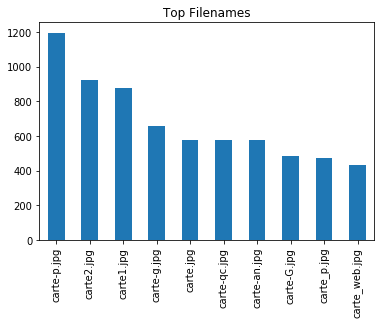

In [51]:
top_filenames_chart = top_filenames.plot(kind='bar', title="Top Filenames", legend=None)

How about a MIME type distribution?



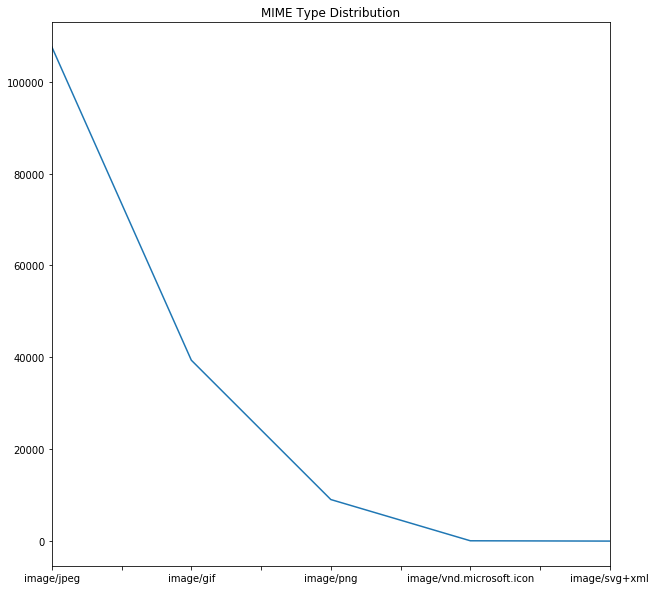

In [78]:
mime_types = images['mime_type_tika'].value_counts().head(5)
mime_type_chart = mime_types.plot.line(title="MIME Type Distribution", figsize=(10,10))

## Domains Analysis

Domains data provides basic information about what is crawled and how often. Change the variables in the following cell to manipulate the domain analysis. For example, you may want to exclude common domains (i.e. "google") or you may be interested in sub-domains such as ca.geocities.com.

Let's start off here by creating a line chart of the top 10 domains.

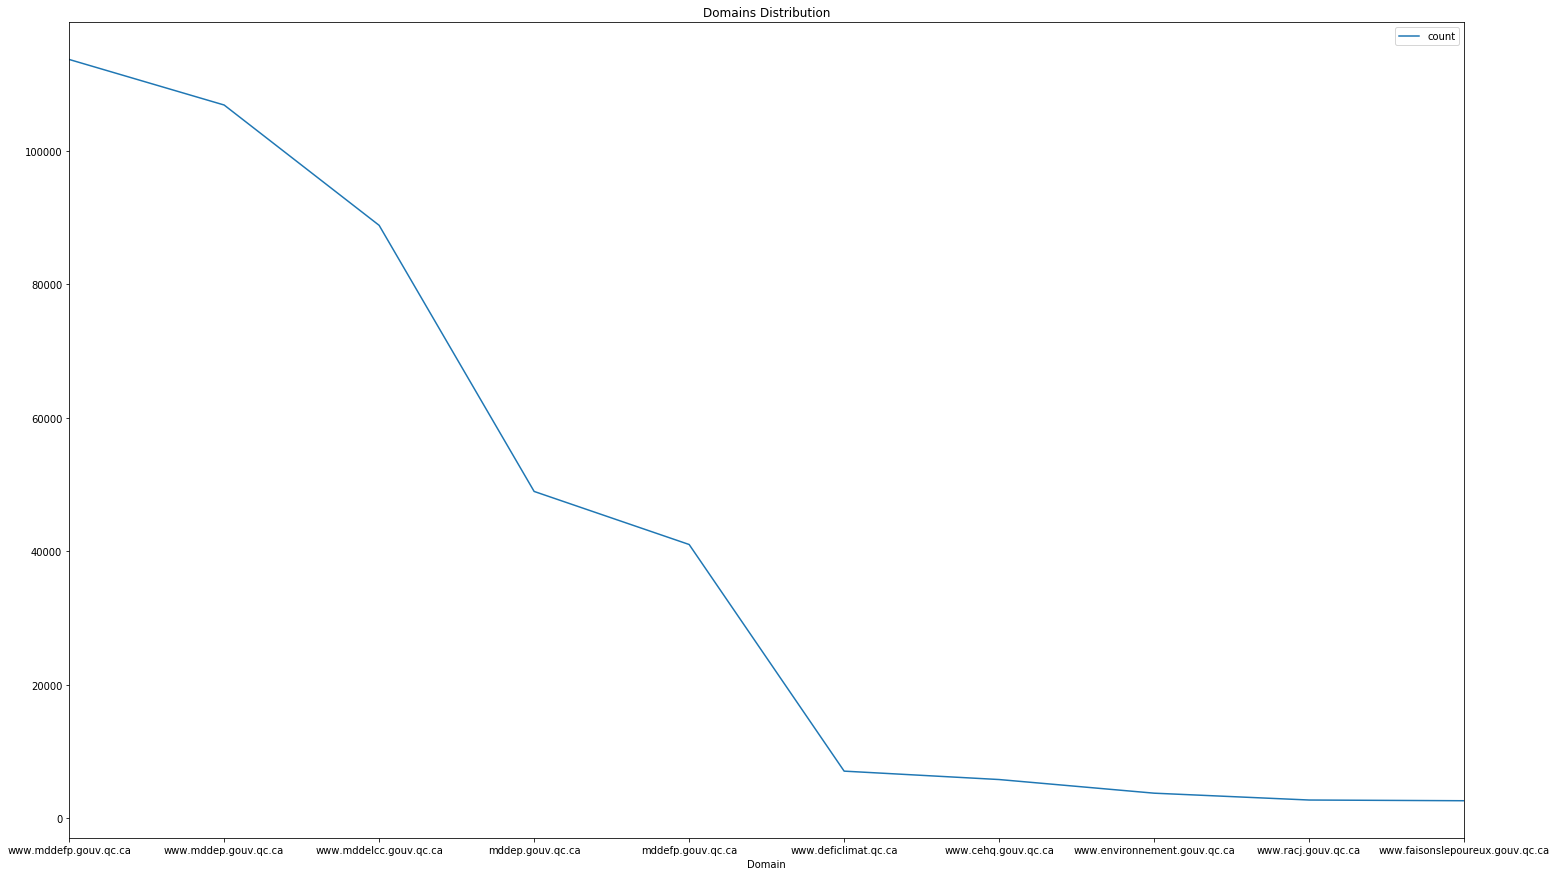

In [95]:
top_domains = domains.sort_values('count', ascending=False).head(10)
top_domains_chart = top_domains.plot.line(title="Domains Distribution", x='Domain', y='count', figsize=(25,15))

Next, we'll be creating a new column, `tld`, which is based off an existing column, 'Domain'. This exapmple should give you an idea of how you can expand these datasets to do further research and analysis.

We'll take the `Domain` column, and extract the `tld` from it with [`tldextract`](https://github.com/john-kurkowski/tldextract).

First we'll add the [`tldextract`](https://github.com/john-kurkowski/tldextract)library to the notebook. Then, we'll create the new column.

In [0]:
%%capture

!pip install tldextract

In [80]:
import tldextract

domains['tld'] = domains.apply(lambda row: tldextract.extract(row.Domain).suffix, axis=1)
domains

,Domain,count,tld
0,www.mddefp.gouv.qc.ca,113680,qc.ca
1,www.mddep.gouv.qc.ca,106857,qc.ca
2,www.mddelcc.gouv.qc.ca,88832,qc.ca
3,mddep.gouv.qc.ca,48971,qc.ca
4,mddefp.gouv.qc.ca,41023,qc.ca
...,...,...,...
321,wwwedu.ge.ch,1,ch
322,r2---sn-9gv7ened.googlevideo.com,1,com
323,www.ncdc.noaa.gov,1,gov
324,r1---sn-9gv7ene6.googlevideo.com,1,com


Next, let's count the distict TLDs.


In [38]:
tld_count = domains['tld'].value_counts()
tld_count

qc.ca    131
com       87
org       34
ca        33
gc.ca     10
gov        8
net        6
co.kr      4
int        3
ch         3
be         2
info       1
edu        1
tv         1
sk.ca      1
eu         1
Name: tld, dtype: int64

Next, we'll plot the TLD count.


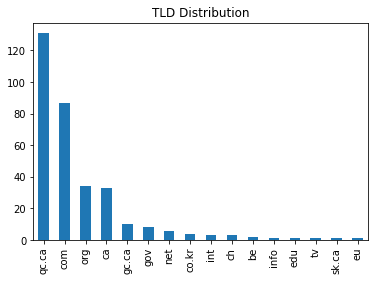

In [46]:
tld_chart = tld_count.plot(kind='bar', title="TLD Distribution", legend=None)